In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import functions2d as fun

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

In [2]:
which = 'laplace'

### Real function:
$$x(t) = e^{-\lambda t}$$

In [3]:
real = fun.function[which]

### Trial function:
$$\hat{f(t)} = 1 + t * N(t)$$

where N(t) is a neural network with 1 input and 1 output

In [4]:
trial = fun.trial[which]

### Differential equation: 
$$\frac{\partial x}{\partial t} = - \lambda x$$

In [5]:
diff_eq = fun.diff_eq[which]
degree = fun.degree[which]

In [6]:
def g(t, nn):
    t1 = t[:, 0]
    t2 = t[:, 1]
    x = trial(nn, t1, t2).view(-1)
    gx = []
    gradx = []
    gradx.append(grad([x], [t1], grad_outputs=torch.ones(t1.shape), create_graph=True)[0])
    gradx.append(grad([x], [t2], grad_outputs=torch.ones(t2.shape), create_graph=True)[0])
    
    gx.append(gradx)
    if degree > 1:
        grad2x = []
        grad2x.append(grad([gradx[0]], [t1], grad_outputs=torch.ones(t1.shape), create_graph=True)[0])
        grad2x.append(grad([gradx[1]], [t2], grad_outputs=torch.ones(t2.shape), create_graph=True)[0])

        gx.append(grad2x)
    z = diff_eq(t, x, gx)
    return z

Define range and neural network parameters

In [7]:
x1_min, x1_max, x2_min, x2_max = fun.interval[which]

n_train = 16

D_in, H, D_out = 2, 200, 1

#### training set:

In [8]:
x1_train = np.linspace(x1_min, x1_max, n_train)
x2_train = np.linspace(x2_min, x2_max, n_train)
X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x = Variable(torch.cat((torch.Tensor(X1_train).view(-1, 1), torch.Tensor(X2_train).view(-1, 1)), 1), requires_grad=True)

Define 
* the neural network architecture (1 hiddel layer, fully connected)
* the loss function (MSE)
* the optimizer (Adam)

In [9]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    #torch.nn.LogSigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out)   
)

criterion = torch.nn.MSELoss(size_average=False)
#criterion = torch.nn.L1Loss(size_average=False)

optimizer = optim.Adam(seq.parameters(), lr=4e-1)
#optimizer = optim.LBFGS(seq.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.01)

### Train the network

In [10]:
n_epoch = 6000
Loss = []
for t in tqdm(range(n_epoch)): 
    y = g(x, seq)
    loss = criterion(y, torch.zeros(y.shape))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    Loss.append(loss.data.numpy())

100%|██████████| 6000/6000 [00:46<00:00, 129.80it/s]


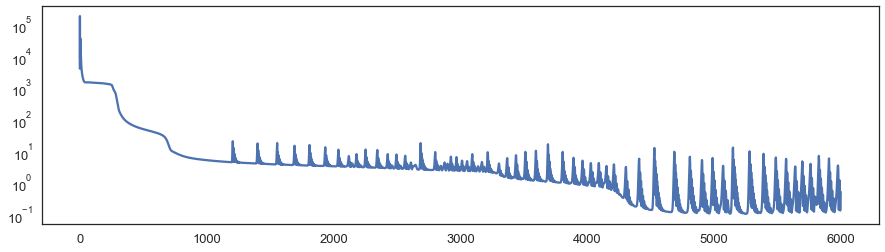

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(Loss)
plt.yscale('log')
plt.show()

### Test data:

In [12]:
n_test = 100
x1_min_test, x1_max_test, x2_min_test, x2_max_test = fun.interval[which]

x1_test = np.linspace(x1_min_test, x1_max_test, n_test)
x2_test = np.linspace(x2_min_test, x2_max_test, n_test)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
x_test = Variable(torch.cat((torch.Tensor(X1_test).view(-1, 1), torch.Tensor(X2_test).view(-1, 1)), 1))

y_test = fun.function[which](x_test).view(X1_test.shape)

##### Trial solution:

In [13]:
y_pred = fun.trial[which](seq, x_test[:, 0], x_test[:, 1]).view(y_test.shape)

print(criterion(y_pred, y_test))

tensor(1.00000e-02 *
       2.2263)


#### Plot of results:

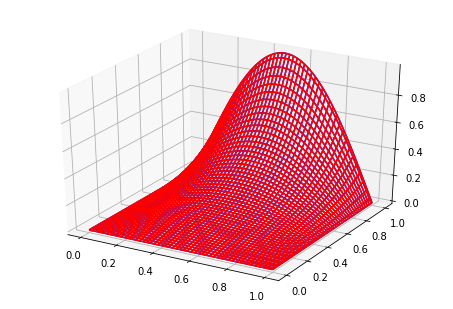

In [14]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X1_test, X2_test, y_test.data.numpy(), color='b', label='real')
ax.plot_wireframe(X1_test, X2_test, y_pred.data.numpy(), color='r', label='predicted')

plt.show()

### Error:

In [15]:
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.plot_wireframe(X1_test, X2_test, y_test.data.numpy()-y_pred.data.numpy())
#plt.legend(scatterpoints=1)
#plt.show()

In [16]:
import seaborn as sns
sns.set(context='talk', style="white", rc={'figure.figsize':[10,10]})


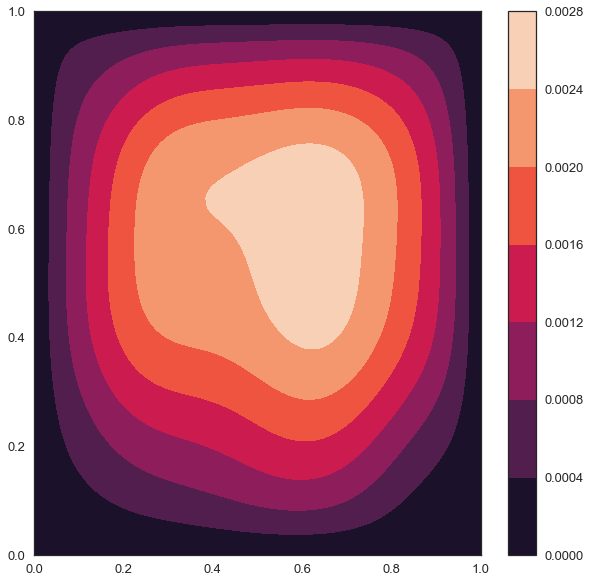

In [17]:
plt.contourf(X1_test, X2_test, abs(y_test.data.numpy()-y_pred.data.numpy()))
plt.colorbar()